In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from gpytorch.kernels import RBFKernel, IndexKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable
from gpytorch.parameters import MLEParameterGroup
from gpytorch.lazy import Kron
from gpytorch.math.functions import CovarIndex
from torch.nn import Parameter

In [3]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = torch.cat([
    Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2).unsqueeze(1),
    Variable(torch.cos(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2).unsqueeze(1),
], 1)

In [4]:
class MultitaskGPModel(gpytorch.ObservationModel):
    def __init__(self):
        super(MultitaskGPModel,self).__init__(GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = RBFKernel()
        self.task_covar_module = IndexKernel()
        self.model_params = MLEParameterGroup(
            constant_mean=Parameter(torch.randn(1)),
            log_noise=Parameter(torch.randn(1)),
            log_lengthscale=Parameter(torch.randn(1)),
        )
        self.task_params = MLEParameterGroup(
            task_matrix=Parameter(torch.randn(2, 1)),
            task_log_vars=Parameter(torch.randn(2)),
        )
        self.task_indices = Variable(torch.arange(0, 2).long())
    
    def forward(self, x):
        mean_x = self.mean_module(x, constant=self.model_params.constant_mean)
        mean_x = mean_x.unsqueeze(1).expand(len(mean_x), 2)
        
        covar_x = self.covar_module(x, log_lengthscale=self.model_params.log_lengthscale)
        covar_i = self.task_covar_module(self.task_indices,
                                         index_covar_factor=self.task_params.task_matrix,
                                         index_log_var=self.task_params.task_log_vars)     
        covar = Kron()(covar_x, covar_i, Variable(torch.zeros(1)))
        
        latent_pred = GaussianRandomVariable(mean_x, covar)
        return latent_pred, self.model_params.log_noise

prior_observation_model = MultitaskGPModel()

In [5]:
def plot_model_and_predictions(observation_model):
    f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))
    test_x = Variable(torch.linspace(0, 1, 51))
    
    pred = observation_model(test_x).evaluate()

    def ax_plot(ax, index, train_y, pred, title):
        lower, upper = pred[:, index].confidence_region()
        ax.plot(train_x.data.numpy(), train_y[:, index].data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), pred[:, index].mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(y1_ax, 0, train_y, pred, 'Observed Values (Likelihood)')
    ax_plot(y2_ax, 1, train_y, pred, 'Observed Values (Likelihood)')
    
    return f

('Inefficient', torch.Size([51, 51]))
torch.Size([51, 51])
('Inefficient', torch.Size([51, 51]))
('Inefficient', torch.Size([51, 51]))
torch.Size([51, 51])
('Inefficient', torch.Size([51, 51]))


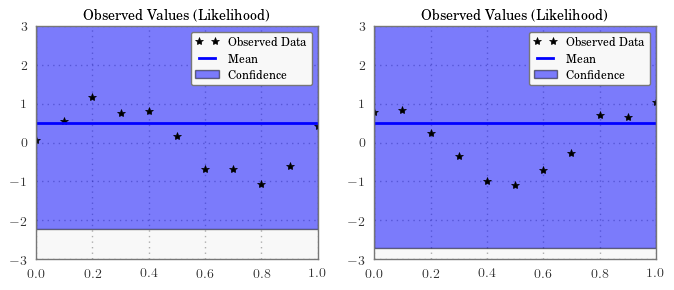

In [6]:
f = plot_model_and_predictions(prior_observation_model)

In [7]:
from gpytorch.inference import Inference

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = Inference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y)

('Inefficient', torch.Size([102, 102]))
('Should be', torch.Size([102, 102]))
('Inefficient', torch.Size([51, 51]))
('Efficient', torch.Size([102, 102]))
('Inefficient', torch.Size([22, 22]))
('Should be', torch.Size([22, 22]))
('Inefficient', torch.Size([11, 11]))
('Efficient', torch.Size([22, 22]))
('Inefficient', torch.Size([102, 22]))
('Should be', torch.Size([102, 22]))
('Inefficient', torch.Size([51, 11]))
('Efficient', torch.Size([102, 22]))
('Inefficient', torch.Size([51, 51]))
torch.Size([51, 51])
('Inefficient', torch.Size([51, 51]))
('Inefficient', torch.Size([51, 51]))
torch.Size([51, 51])
('Inefficient', torch.Size([51, 51]))


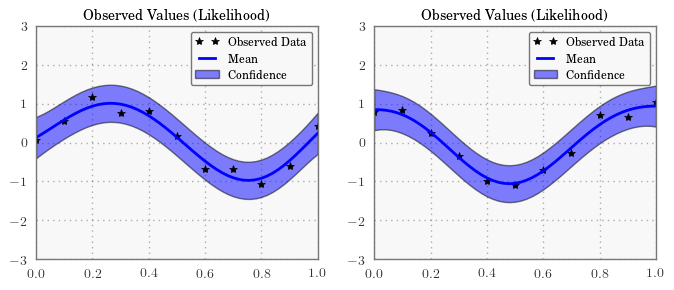

In [8]:
f = plot_model_and_predictions(posterior_observation_model)